In the previous notebook, Univariate Probabilistic Linear Regression, we implemented some methods to account for what can be considered to be aleatoric uncertainty. 

In this notebook, we'll implement methods to account for the epistemic uncertainty. Epistemic uncertainty is something akin to model uncertainty.

# BNN for Univariate Regression

This notebook was adapted from various sources, specially from google's tutorial, Coursera's Probabilistic Programming course.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import pydot
import graphviz

In [2]:
tfd = tfp.distributions
tfpl = tfp.layers

sns.set()

In [3]:
def syn_dataset3(n=150, n_tst=150,beta=2):
    # to allow for reproducibility 
    # np.random.seed(43)
    x =np.sort(np.random.rand(n))
    eps = ((x-0.5)**2.)*np.random.randn(n)
    
    y = ((x**5)+eps)[:, np.newaxis]
    x = x[:, np.newaxis]
    
    x_tst = np.linspace(np.min(x),np.max(x), num=n_tst).astype(np.float32)
    x_tst = x_tst[:, np.newaxis]
    return y, x, x_tst

# it seems that we need more data, since we'll be estimating more parameters
y_syn_ds3, x_syn_ds3, x_tst_syn_ds3 = syn_dataset3(n=1000)

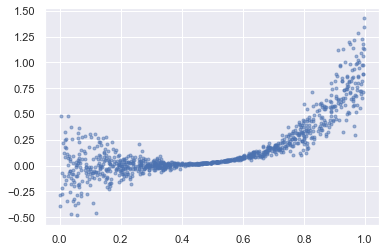

In [4]:
 plt.scatter(x_syn_ds3, y_syn_ds3, marker='.', alpha=0.5, label='data')

In [18]:
def plot_model(x,y,n_range,model,x_test=np.array([])):
    plt.scatter(x, y, marker='.', alpha=0.5, label='data')
    if x_test.size==0:
        x_test=x
    for _ in range(n_range):
        y_model = model(x_test)
        y_hat = y_model.mean()
        y_hat_m2sd = y_hat - 2 * y_model.stddev()
        y_hat_p2sd = y_hat + 2 * y_model.stddev()
        if _ == 0:
            plt.plot(x_test, y_hat, color='red', alpha=0.8, label='model $\mu$')
            plt.plot(x_test, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
            plt.plot(x_test, y_hat_p2sd, color='green', alpha=0.8)
        else:
            plt.plot(x_test, y_hat, color='red', alpha=0.8)
            plt.plot(x_test, y_hat_m2sd, color='green', alpha=0.8)
            plt.plot(x_test, y_hat_p2sd, color='green', alpha=0.8)        
    plt.legend()
    plt.show()

In [6]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential([
        tfpl.DistributionLambda(lambda t : tfd.MultivariateNormalDiag(loc=tf.zeros(n),
                                                                      scale_diag=tf.ones(n))),
    ])
    return prior_model

In [7]:
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

In [8]:
model = tf.keras.Sequential([
    tfpl.DenseVariational(units=8,
                          input_shape=(1,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_syn_ds3.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_syn_ds3.shape[0]),
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005))
#model.summary()

In [9]:
model.fit(x_syn_ds3, y_syn_ds3, epochs=1000, verbose=False)
model.evaluate(x_syn_ds3, y_syn_ds3)

32/32 [==============================] - 2s 2ms/step - loss: -0.6077


-0.607699990272522

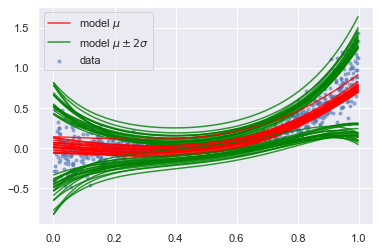

In [20]:
plot_model(x_syn_ds3, y_syn_ds3,20,model,x_tst_syn_ds3)

Notice that our model has some trouble fitting the 'mean' (too concentrated on the right side), and the right-hand side of the std-dev. We can improve on this...

# A Functional Approach

In [11]:
N=x_syn_ds3.shape[0]

In [12]:
# It seems that it's very easy for the method below to go awry...
# If we add more layers, and/or increase the number of neurons, its performance will decrease,
# or its fitting time will increase 'exponentially'


inputs = tf.keras.layers.Input(shape=(1,)) 
hidden1_sd = tfpl.DenseVariational(16, make_posterior_fn=posterior, 
                                  make_prior_fn=prior, kl_weight=1/N, activation='sigmoid')(inputs)
std_dev_layer = tfpl.DenseVariational(1,make_posterior_fn=posterior, 
                                  make_prior_fn=prior, kl_weight=1/N)(hidden1_sd)

hidden1_m = tfpl.DenseVariational(5, make_posterior_fn=posterior, 
                                 make_prior_fn=prior, kl_weight=1/N, activation='sigmoid')(inputs)

mean_layer = tfpl.DenseVariational(1, make_posterior_fn=posterior, 
                                  make_prior_fn=prior, kl_weight=1/N)(hidden1_m)

params = tf.keras.layers.Concatenate()([mean_layer,std_dev_layer]) 
dist = tfp.layers.DistributionLambda(
    lambda t: tfd.Normal(loc=t[:,:1],scale=1e-5+tf.math.softplus(t[:, 1:]))
    )(params) 

#dist= tfpl.IndependentNormal(1)(params)

model_flex_both = tf.keras.Model(inputs=inputs, outputs=dist)

In [13]:
model_flex_both.compile(loss=nll, optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.005))
model_flex_both.fit(x_syn_ds3, y_syn_ds3, epochs=1000, verbose=False)
model_flex_both.evaluate(x_syn_ds3, y_syn_ds3)

32/32 [==============================] - 4s 3ms/step - loss: -0.7934


-0.7934220433235168

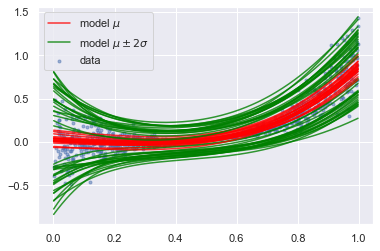

In [19]:
plot_model(x_syn_ds3, y_syn_ds3,20,model_flex_both,x_tst_syn_ds3)

We can see that our model now fits much better the data.